In [16]:
#!pip install jax
#!pip install -U "jax[cpu]"
#!pip install mat73
#!pip install scikit-learn-extra 
# Comment out the lines above after running them once. 
#!pip install pandas
#!pip install seaborn

# Importing the libraries
import sys
import psutil
import time
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from scipy import signal
from scipy.signal import find_peaks
import json
import mat73
import math
import os
import pandas as pd

In [2]:
def compare_sources(list1, list2, tolerance):
    #tolerance = 5
    duplicate_matches = 0

    list1_matches = set()
    list2_matches = set()
    list1_duplicates = set()
    list2_duplicates = set()

    for  spike_idx in list1:
        for spike2_idx in list2:
            #print(f'Cheking: {spike_idx} & {spike2_idx}')
            #print(f'Difference: {abs(spike_idx-spike2_idx)}')

            if  abs(spike_idx-spike2_idx) < tolerance:  
                if spike_idx not in list1_matches and spike2_idx not in list2_matches:
                    
                    # Add the spike pair to the matched spikes
                    list1_matches.add(spike_idx)
                    list2_matches.add(spike2_idx)

                else:
                    # Add the spike pair to the duplicate list
                    list1_duplicates.add(spike_idx)
                    list2_duplicates.add(spike2_idx)

                    # Incriment the duplicate counter
                    duplicate_matches += 1


            if (spike_idx - spike2_idx) < - tolerance:
                #print('There is no way back!')
                break

    list1_duplicates = list1_duplicates - list1_matches
    list2_duplicates = list2_duplicates - list2_matches

    matched_count = len(list1_matches) + len(list2_matches)
    spikes_with_duplicates = len(set(list1_duplicates)) + len(set(list2_duplicates))
    unmatched_count = len(list1) + len(list2) - matched_count - len(list1_duplicates) - len(list2_duplicates)
    rate_of_agreement = (matched_count / (matched_count + unmatched_count + spikes_with_duplicates)) * 100

    return matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement

In [3]:
# Fetch the true sources
file_path = '../data/SIMULATION_56_40.mat'
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)

# Extract the EMG spike data into a numpy array
MUPulses = np.array(data_dict['MUPulses'][0])
print(MUPulses.shape)
print(MUPulses[40].shape)

(56,)
(1, 719)


In [13]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../output.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
dup_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

print(roa_matrix.shape)

# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    for idxB, sourceB in enumerate(MUPulsesB):
        sourceB = sourceB["SpikeTrain"]
        matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement = compare_sources(sourceA, sourceB, roa_tolerance)

        roa_matrix.iloc[idxA, idxB] = np.round(rate_of_agreement).astype(int)
        dup_matrix.iloc[idxA, idxB] = spikes_with_duplicates


print(roa_matrix)
print(dup_matrix)

(56, 47)
    0   1   2   3   4   5   6   7   8   9   ...  37  38  39  40  41  42  43  \
0   21  20  20  19  20  35  20  66  19  20  ...  21  20  21  19  20  36  20   
1   21  20  20  20  20  35  20  66  19  20  ...  22  20  21  20  20  36  20   
2   21  20  20  19  20  35  20  67  19  20  ...  21  20  21  19  20  36  20   
3   21  20  20  20  20  35  20  67  19  20  ...  21  19  21  20  20  36  20   
4   21  20  20  20  21  36  20  66  20  20  ...  22  20  21  20  20  37  20   
5   21  20  20  20  20  35  20  66  19  20  ...  21  20  21  19  20  36  20   
6   21  20  20  20  20  35  20  67  19  20  ...  21  20  21  20  20  36  19   
7   20  20  20  19  20  35  20  66  19  20  ...  21  19  20  19  19  36  19   
8   21  20  20  20  20  35  20  66  20  20  ...  22  20  21  20  20  36  20   
9   21  20  20  20  20  36  20  66  19  20  ...  22  20  21  19  19  36  20   
10  20  20  20  19  20  35  20  66  19  20  ...  21  19  20  19  20  36  19   
11  21  20  20  19  20  35  20  67  19  20 

<Axes: >

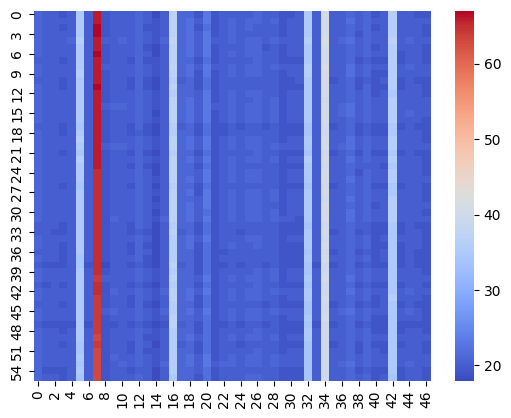

In [14]:
import seaborn as sns
sns.heatmap(roa_matrix, cmap='coolwarm')

<Axes: >

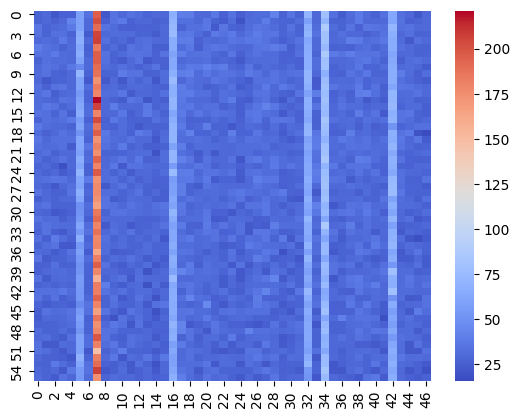

In [15]:
sns.heatmap(dup_matrix, cmap='coolwarm')